In [1]:
# Importing necessary libraries
from matplotlib import legend
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
import numpy as np
from icecream import ic
from tqdm import tqdm
from itertools import chain
import logging
import os
import cProfile
import pstats
#from dataloader import *
from get_data import *
from torch.utils.data import Dataset, DataLoader

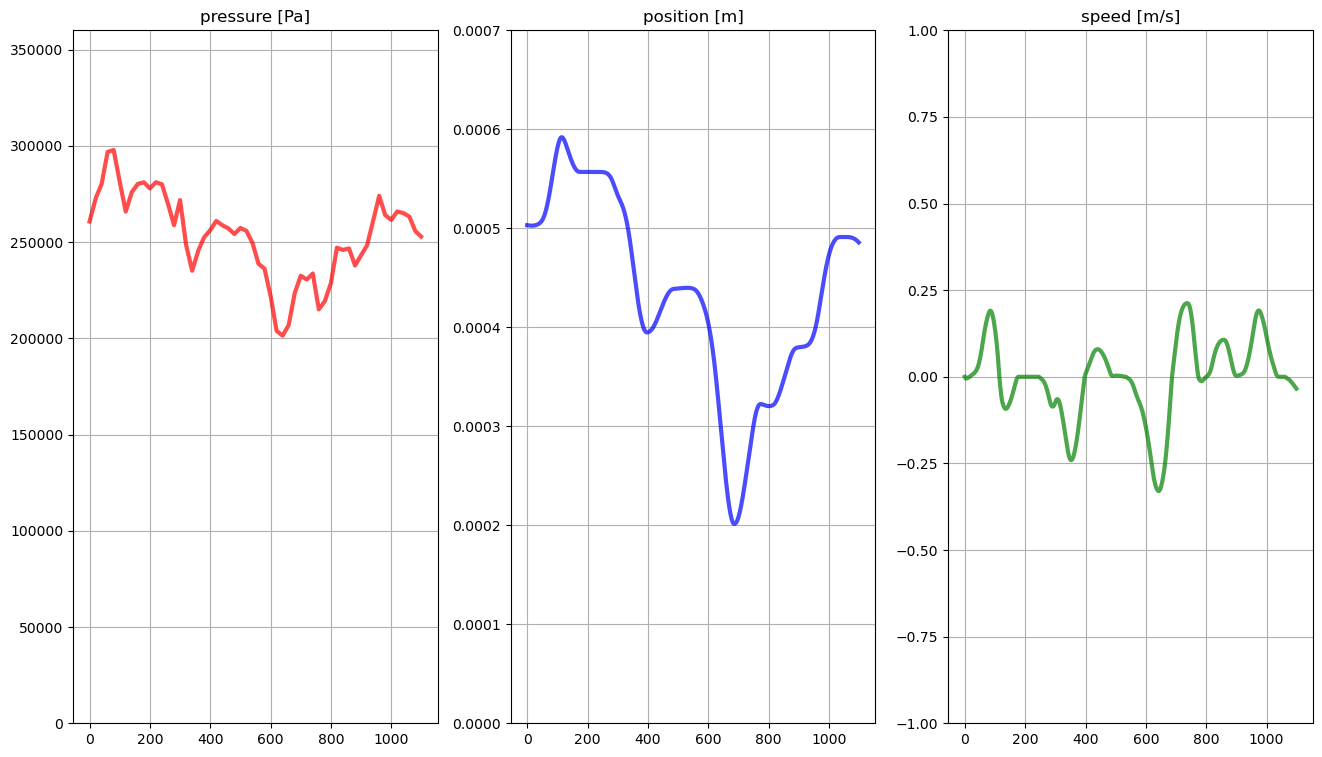

In [2]:
visualise(get_data(path = "save_data_test3.csv", timesteps_from_data=0, skip_steps_start = 0, skip_steps_end = 0, 
                   drop_half_timesteps = False, normalise_s_w=False, rescale_p=False, num_inits=100), num_inits=10, set_ylim=True)

In [44]:
#custom dataclass

#This custom dataclass moves a sliding window over a timeseries and returns
# inp(0:t) and label(t+1)
#if values are missing the last value is used for padding sind 
#Structure of the data:
# (number of timeseries // timesteps // features)
# if index+window_size > timesteps  >>> padding

import torch.utils
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, window_size, future=1):

        self.data = data
        self.ws = window_size
        self.future = future

    def __len__(self):
        return self.data.size(0)*self.data.size(1) - (self.ws + 1) - (self.future-1)

    def __getitem__(self, idx):

        j = int(idx/self.data.size(1))  

        k = int((idx + self.ws + (self.future-1)) / self.data.size(1))

        m = (idx + self.ws + (self.future-1)) - k * self.data.size(1)

        index = idx % self.data.size(1)

        if j < k :

            inp=torch.cat((self.data[j, index : self.data.size(1) , :],
                          self.data[j, self.data.size(1) - 1, :].repeat(m, 1)))
            if self.future>1:
                print("got here, index:", j, self.data.size(1) - 1)
                label = self.data[j, self.data.size(1) - 1, :].repeat(self.future, 1)        
            else:
                label = self.data[j, self.data.size(1) - 1, :]
                
            
        else:

            inp = self.data[j, index : index + self.ws, :]

            if self.future>1:
                print("normal label with index:", j, index+self.ws, "bis ", index + self.ws + self.future)
                label = self.data[j, index + self.ws : index + self.ws + self.future  , :]
            else:
                label = self.data[j, index + self.ws, :]

        return inp, label

    def get_all_data(self):
        return self.data

In [46]:
input_data = get_data(path = "save_data_test3.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = False,
                        normalise_s_w=True,
                        rescale_p=False,
                        num_inits=3)

cut_off_timesteps = 1050

#Split data into train and test sets
percentage_of_data = 0.9
window_size = 4
batch_size = 1

num_of_inits_train = int(len(input_data)*percentage_of_data)
train_inits = np.random.randint(0,len(input_data), num_of_inits_train)
train_inits = np.unique(train_inits)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])

# make sure we really get the specified percentage of training data..
if percentage_of_data < 0.99: 
        while len(train_inits) < num_of_inits_train:
            i = np.random.randint(0,len(test_inits),1)[0]
            train_inits = np.append(train_inits,test_inits[i])
            test_inits = np.delete(test_inits, i)

train_data = input_data[train_inits,:input_data.size(dim=1)-cut_off_timesteps,:]
test_data = input_data[test_inits,:,:]

data_set  = CustomDataset(train_data, window_size=window_size, future=2)
train_dataloader = DataLoader(data_set, batch_size=batch_size, pin_memory=True, drop_last=True)

In [48]:
print(train_data.size())
for k, (x,y) in enumerate(train_dataloader):
    #print(x)
    #print("label:",y)
    print("timestep mit label simma bei t = ", k, ":", k+(window_size+2))
    print(x)
    print(y)

torch.Size([2, 50, 3])
normal label with index: 0 4 bis  6
timestep mit label simma bei t =  0 : 6
tensor([[[-0.4467, -0.5580,  0.1031],
         [-0.4597, -0.5581,  0.0834],
         [-0.4726, -0.5584,  0.0676],
         [-0.4855, -0.5588,  0.0531]]], dtype=torch.float64)
tensor([[[-0.4985, -0.5594,  0.0386],
         [-0.5114, -0.5601,  0.0236]]], dtype=torch.float64)
normal label with index: 0 5 bis  7
timestep mit label simma bei t =  1 : 7
tensor([[[-0.4597, -0.5581,  0.0834],
         [-0.4726, -0.5584,  0.0676],
         [-0.4855, -0.5588,  0.0531],
         [-0.4985, -0.5594,  0.0386]]], dtype=torch.float64)
tensor([[[-0.5114, -0.5601,  0.0236],
         [-0.5244, -0.5609,  0.0076]]], dtype=torch.float64)
normal label with index: 0 6 bis  8
timestep mit label simma bei t =  2 : 8
tensor([[[-0.4726, -0.5584,  0.0676],
         [-0.4855, -0.5588,  0.0531],
         [-0.4985, -0.5594,  0.0386],
         [-0.5114, -0.5601,  0.0236]]], dtype=torch.float64)
tensor([[[-0.5244, -0.5609

In [6]:
ws= 3
n = 2

data = get_data(path = "save_data_test3.csv", timesteps_from_data=0, skip_steps_start = 0, skip_steps_end = 1000, drop_half_timesteps = True, normalise_s_w=False, rescale_p=False, num_inits=n)
data_set = CustomDataset(data, window_size=ws, future=1)
dataloader = DataLoader(data_set, batch_size=2)

time = np.linspace(0,data.size(dim=1)*n,data.size(dim=1)*n)
print(data.size())
for i, (inp, label) in enumerate(dataloader):
    #print("input" , inp)
    #print("label",label)
    print(i, label.size())

torch.Size([2, 100, 3])
0 torch.Size([2, 3])
1 torch.Size([2, 3])
2 torch.Size([2, 3])
3 torch.Size([2, 3])
4 torch.Size([2, 3])
5 torch.Size([2, 3])
6 torch.Size([2, 3])
7 torch.Size([2, 3])
8 torch.Size([2, 3])
9 torch.Size([2, 3])
10 torch.Size([2, 3])
11 torch.Size([2, 3])
12 torch.Size([2, 3])
13 torch.Size([2, 3])
14 torch.Size([2, 3])
15 torch.Size([2, 3])
16 torch.Size([2, 3])
17 torch.Size([2, 3])
18 torch.Size([2, 3])
19 torch.Size([2, 3])
20 torch.Size([2, 3])
21 torch.Size([2, 3])
22 torch.Size([2, 3])
23 torch.Size([2, 3])
24 torch.Size([2, 3])
25 torch.Size([2, 3])
26 torch.Size([2, 3])
27 torch.Size([2, 3])
28 torch.Size([2, 3])
29 torch.Size([2, 3])
30 torch.Size([2, 3])
31 torch.Size([2, 3])
32 torch.Size([2, 3])
33 torch.Size([2, 3])
34 torch.Size([2, 3])
35 torch.Size([2, 3])
36 torch.Size([2, 3])
37 torch.Size([2, 3])
38 torch.Size([2, 3])
39 torch.Size([2, 3])
40 torch.Size([2, 3])
41 torch.Size([2, 3])
42 torch.Size([2, 3])
43 torch.Size([2, 3])
44 torch.Size([2, 

In [7]:
a,b = next(iter(dataloader))
c, d = next(iter(dataloader))

print(a,b)
print(c,d)

tensor([[[2.2950e+05, 2.6985e-04, 0.0000e+00],
         [2.3104e+05, 2.6993e-04, 7.9591e-03],
         [2.3258e+05, 2.7016e-04, 1.4714e-02]],

        [[2.3104e+05, 2.6993e-04, 7.9591e-03],
         [2.3258e+05, 2.7016e-04, 1.4714e-02],
         [2.3412e+05, 2.7052e-04, 2.2013e-02]]], dtype=torch.float64) tensor([[2.3412e+05, 2.7052e-04, 2.2013e-02],
        [2.3566e+05, 2.7104e-04, 3.0136e-02]], dtype=torch.float64)
tensor([[[2.2950e+05, 2.6985e-04, 0.0000e+00],
         [2.3104e+05, 2.6993e-04, 7.9591e-03],
         [2.3258e+05, 2.7016e-04, 1.4714e-02]],

        [[2.3104e+05, 2.6993e-04, 7.9591e-03],
         [2.3258e+05, 2.7016e-04, 1.4714e-02],
         [2.3412e+05, 2.7052e-04, 2.2013e-02]]], dtype=torch.float64) tensor([[2.3412e+05, 2.7052e-04, 2.2013e-02],
        [2.3566e+05, 2.7104e-04, 3.0136e-02]], dtype=torch.float64)


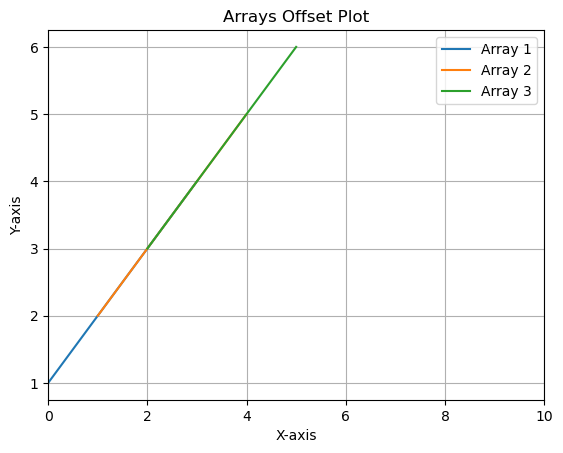

In [8]:


import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = np.arange(10)  # Extend the range of x-values
y1 = np.array([1, 2, 3, 4])
y2 = np.array([2, 3, 4, 5])
y3 = np.array([3, 4, 5, 6])

# Plot each array with offset
plt.plot(x[:4], y1, label='Array 1')
plt.plot(x[1:5], y2, label='Array 2')
plt.plot(x[2:6], y3, label='Array 3')
plt.xlim(0,10)
# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Arrays Offset Plot')
plt.legend()

# Show plot
plt.grid(True)
plt.show()